In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
#import warnings
from copy import deepcopy

from Classes.marketmodel_interface import MarketModel
from Classes.simulation_interface import Simulation

#### Import data for calibration
CAC40

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

data = histo_CAC40.dropna()
nb_stocks = 40
allocations_EW = np.ones(nb_stocks) / nb_stocks
# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values


In [3]:
logreturn_data = np.log(data / data.shift() )
logreturn_data.iloc[0,:] = 0.0


begin_date_data = str(data.index[0])[:10]
end_date_data = str(data.index[-1])[:10]

In [4]:
print(begin_date_data)
print(end_date_data)

2018-06-05
2025-03-07


#### Create Black-Scholes model and calibrate it with data

In [5]:
# Create a MarketModel object
market_model_BS_CAC40 = MarketModel(model_name="BS")
market_model_BS_CAC40.fit(data)

#### Simulation with historical data

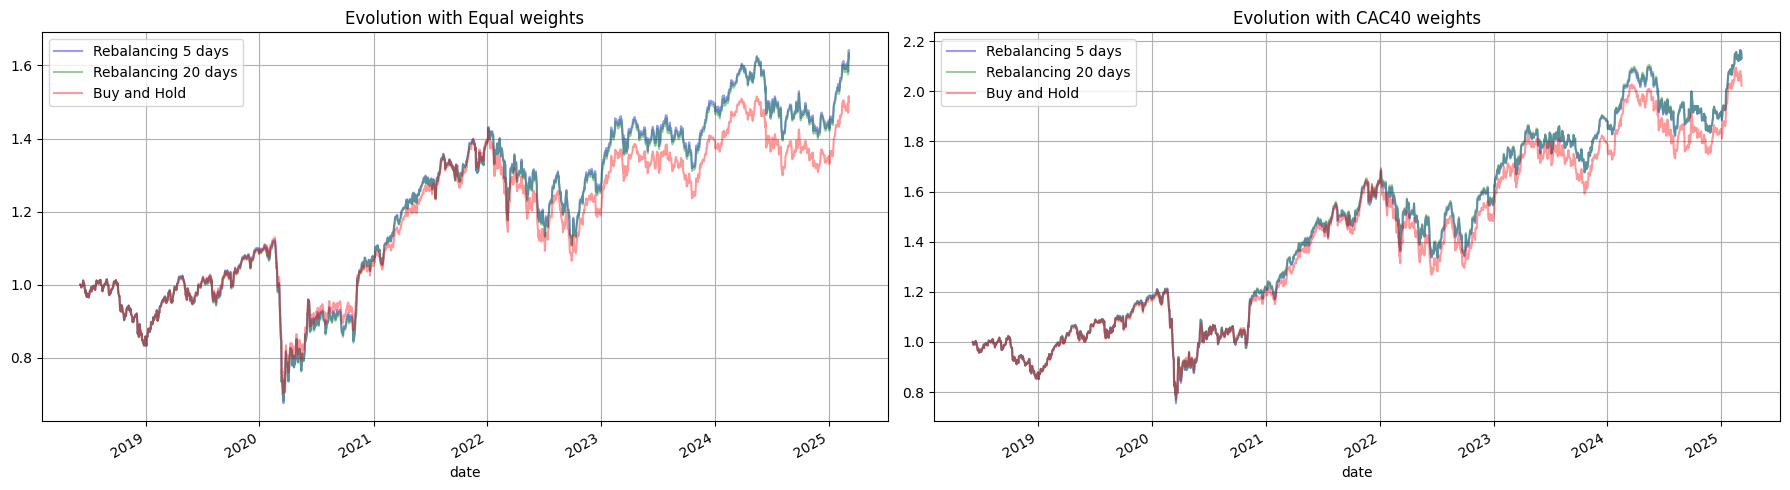

In [6]:
# Evolution des stratégies sans recalcul de l'allocation

scenario_histo = {
    'Scenario 1' : logreturn_data
}

allocation = CAC40_weights

parameters_BuyH_histo = {
    "Begin date": begin_date_data,
    "End date": end_date_data,
    "Allocation": allocation,
}
simulation_BuyH_histo = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH_histo)
simulation_BuyH_histo.set_scenarios(scenario_histo)
simulation_BuyH_histo.generate_evolutions()

parameters_Rebal5_histo = {
    "Begin date": begin_date_data,
    "End date": end_date_data,
    "Allocation": allocation,
    "Rebalancing period": 5
}
simulation_Rebal5_histo = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal5_histo)
simulation_Rebal5_histo.set_scenarios(scenario_histo)
simulation_Rebal5_histo.generate_evolutions()

parameters_Rebal20_histo = {
    "Begin date": begin_date_data,
    "End date": end_date_data,
    "Allocation": allocation,
    "Rebalancing period": 20
}
simulation_Rebal20_histo = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal20_histo)
simulation_Rebal20_histo.set_scenarios(scenario_histo)
simulation_Rebal20_histo.generate_evolutions()

# Run simulations with equal weight allocation
if True :
    parameters_BuyH_histo_EW = {
        "Begin date": begin_date_data,
        "End date": end_date_data,
        "Allocation": allocations_EW,
    }
    simulation_BuyH_histo_EW = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH_histo_EW)
    simulation_BuyH_histo_EW.set_scenarios(scenario_histo)
    simulation_BuyH_histo_EW.generate_evolutions()

    parameters_Rebal5_histo_EW = {
        "Begin date": begin_date_data,
        "End date": end_date_data,
        "Allocation": allocations_EW,
        "Rebalancing period": 5
    }
    simulation_Rebal5_histo_EW = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal5_histo_EW)
    simulation_Rebal5_histo_EW.set_scenarios(scenario_histo)
    simulation_Rebal5_histo_EW.generate_evolutions()

    parameters_Rebal20_histo_EW = {
        "Begin date": begin_date_data,
        "End date": end_date_data,
        "Allocation": allocations_EW,
        "Rebalancing period": 20
    }
    simulation_Rebal20_histo_EW = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal20_histo_EW)
    simulation_Rebal20_histo_EW.set_scenarios(scenario_histo)
    simulation_Rebal20_histo_EW.generate_evolutions()

# Create subplot with 2 figures
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(18, 5))

# Plot CAC40 weights strategies
evolution_rebal5 = simulation_Rebal5_histo.evolutions
evolution_BuyH = simulation_BuyH_histo.evolutions
evolution_rebal20 = simulation_Rebal20_histo.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    evolution_data.sum(axis=1).plot(ax=ax1, color="blue", alpha=0.4, label="Rebalancing 5 days")
    evolution_rebal20[evolution_name].sum(axis=1).plot(ax=ax1, color="green", alpha=0.4, label="Rebalancing 20 days")
    evolution_BuyH[evolution_name].sum(axis=1).plot(ax=ax1, color="red", alpha=0.4, label="Buy and Hold")

ax1.set_title("Evolution with CAC40 weights")
ax1.grid()
ax1.legend()

# Plot Equal weights strategies
evolution_rebal5_EW = simulation_Rebal5_histo_EW.evolutions
evolution_BuyH_EW = simulation_BuyH_histo_EW.evolutions
evolution_rebal20_EW = simulation_Rebal20_histo_EW.evolutions

for evolution_name, evolution_data in evolution_rebal5_EW.items():
    evolution_data.sum(axis=1).plot(ax=ax2, color="blue", alpha=0.4, label="Rebalancing 5 days")
    evolution_rebal20_EW[evolution_name].sum(axis=1).plot(ax=ax2, color="green", alpha=0.4, label="Rebalancing 20 days")
    evolution_BuyH_EW[evolution_name].sum(axis=1).plot(ax=ax2, color="red", alpha=0.4, label="Buy and Hold")

ax2.set_title("Evolution with Equal weights")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

In [7]:
# Evolution des stratégies avec recalcul de l'allocation

scenario_histo = {
    'Scenario 1' : logreturn_data
}
Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :]).T
#string to float
Data_esg = Data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
contraints = {
    "List" : ["Maximal allocation", "Maximal volatility"],
    "Value" : [0.1, 0.4]
}

allocation = allocations_EW

parameters_BuyH_histo = {
    "Begin date": begin_date_data,
    "End date": end_date_data,
    "Allocation": allocation,
}
simulation_BuyH_histo_Talloc3M = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH_histo)
simulation_BuyH_histo_Talloc3M.set_scenarios(scenario_histo)
simulation_BuyH_histo_Talloc3M.set_dataESG(Data_esg)
simulation_BuyH_histo_Talloc3M.set_contraints(contraints)
simulation_BuyH_histo_Talloc3M.generate_evolutions(T_allocation = int(365.25*5/7  //4))

simulation_BuyH_histo_Talloc6M = deepcopy(simulation_BuyH_histo_Talloc3M)
simulation_BuyH_histo_Talloc6M.generate_evolutions(T_allocation = int(365.25*5/7  //2))

simulation_BuyH_histo_Talloc1Y = deepcopy(simulation_BuyH_histo_Talloc3M)
simulation_BuyH_histo_Talloc1Y.generate_evolutions(T_allocation = int(365.25*5/7))

simulation_BuyH_histo_Talloc2Y = deepcopy(simulation_BuyH_histo_Talloc3M)
simulation_BuyH_histo_Talloc2Y.generate_evolutions(T_allocation = int(365.25*5/7 * 2))

simulation_BuyH_histo_Talloc4Y = deepcopy(simulation_BuyH_histo_Talloc3M)
simulation_BuyH_histo_Talloc4Y.generate_evolutions(T_allocation = int(365.25*5/7 * 4))
# without recomputing allocation
simulation_BuyH_histo_TallocWre = deepcopy(simulation_BuyH_histo_Talloc3M)
simulation_BuyH_histo_TallocWre.generate_evolutions(T_allocation = 0)



# Run simulations with rebalancing all 2weeks
if True :
    parameters_Rebal10_histo = {
        "Begin date": begin_date_data,
        "End date": end_date_data,
        "Allocation": allocation,
        "Rebalancing period": 10
    }
    simulation_Rebal10_histo_Talloc3M = Simulation(nb_scenarios=1, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal5_histo_EW)
    simulation_Rebal10_histo_Talloc3M.set_scenarios(scenario_histo)
    simulation_Rebal10_histo_Talloc3M.set_dataESG(Data_esg)
    simulation_Rebal10_histo_Talloc3M.set_contraints(contraints)
    simulation_Rebal10_histo_Talloc3M.generate_evolutions(T_allocation = int(365.25*5/7  //4))

    simulation_Rebal10_histo_Talloc6M = deepcopy(simulation_Rebal10_histo_Talloc3M)
    simulation_Rebal10_histo_Talloc6M.generate_evolutions(T_allocation = int(365.25*5/7 //2))

    simulation_Rebal10_histo_Talloc1Y = deepcopy(simulation_Rebal10_histo_Talloc3M)
    simulation_Rebal10_histo_Talloc1Y.generate_evolutions(T_allocation = int(365.25*5/7))

    simulation_Rebal10_histo_Talloc2Y = deepcopy(simulation_Rebal10_histo_Talloc3M)
    simulation_Rebal10_histo_Talloc2Y.generate_evolutions(T_allocation = int(365.25*5/7 *2))

    simulation_Rebal10_histo_Talloc4Y = deepcopy(simulation_Rebal10_histo_Talloc3M)
    simulation_Rebal10_histo_Talloc4Y.generate_evolutions(T_allocation = int(365.25*5/7 *4))

    simulation_Rebal10_histo_TallocWre = deepcopy(simulation_Rebal10_histo_Talloc3M)
    simulation_Rebal10_histo_TallocWre.generate_evolutions(T_allocation = 0)

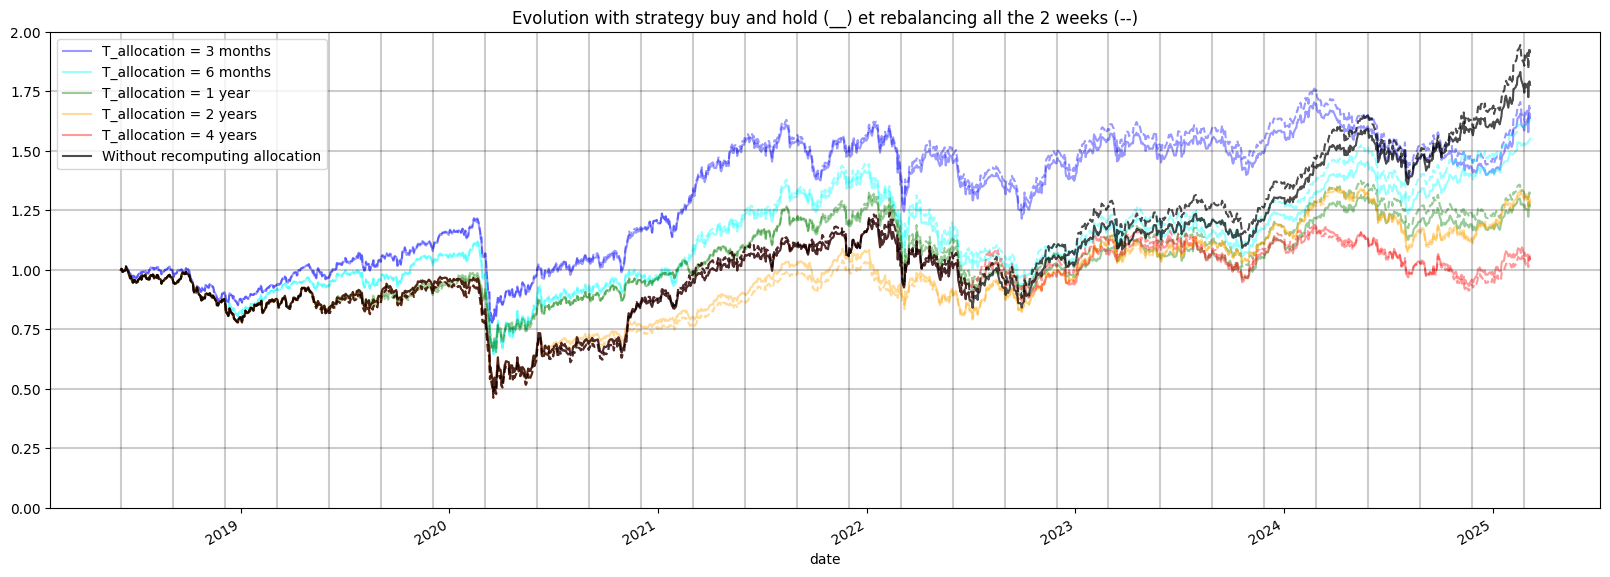

In [8]:
plt.figure(figsize=(20, 7))

lines = []

# Plot buy and hold
evolution_BuyH_histo_Talloc3M = simulation_BuyH_histo_Talloc3M.evolutions
evolution_BuyH_histo_Talloc6M = simulation_BuyH_histo_Talloc6M.evolutions
evolution_BuyH_histo_Talloc1Y = simulation_BuyH_histo_Talloc1Y.evolutions
evolution_BuyH_histo_Talloc2Y = simulation_BuyH_histo_Talloc2Y.evolutions
evolution_BuyH_histo_Talloc4Y = simulation_BuyH_histo_Talloc4Y.evolutions
evolution_BuyH_histo_TallocWre = simulation_BuyH_histo_TallocWre.evolutions

evolution_Rebal10_histo_Talloc3M = simulation_Rebal10_histo_Talloc3M.evolutions
evolution_Rebal10_histo_Talloc6M = simulation_Rebal10_histo_Talloc6M.evolutions
evolution_Rebal10_histo_Talloc1Y = simulation_Rebal10_histo_Talloc1Y.evolutions
evolution_Rebal10_histo_Talloc2Y = simulation_Rebal10_histo_Talloc2Y.evolutions
evolution_Rebal10_histo_Talloc4Y = simulation_Rebal10_histo_Talloc4Y.evolutions
evolution_Rebal10_histo_TallocWre = simulation_Rebal10_histo_TallocWre.evolutions


for evolution_name, evolution_data in evolution_BuyH_histo_Talloc3M.items():

    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="T_allocation = 3 months"))
    lines.append(evolution_Rebal10_histo_Talloc3M[evolution_name].sum(axis=1).plot(color="blue", linestyle='--', alpha=0.4))

    lines.append(evolution_BuyH_histo_Talloc6M[evolution_name].sum(axis=1).plot(color="cyan", alpha=0.4, label="T_allocation = 6 months"))
    lines.append(evolution_Rebal10_histo_Talloc6M[evolution_name].sum(axis=1).plot(color="cyan", linestyle='--', alpha=0.4))

    lines.append(evolution_BuyH_histo_Talloc1Y[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="T_allocation = 1 year"))
    lines.append(evolution_Rebal10_histo_Talloc1Y[evolution_name].sum(axis=1).plot(color="green", linestyle='--', alpha=0.4))

    lines.append(evolution_BuyH_histo_Talloc2Y[evolution_name].sum(axis=1).plot(color="orange", alpha=0.4, label="T_allocation = 2 years"))
    lines.append(evolution_Rebal10_histo_Talloc2Y[evolution_name].sum(axis=1).plot(color="orange", linestyle='--', alpha=0.4))

    lines.append(evolution_BuyH_histo_Talloc4Y[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="T_allocation = 4 years"))
    lines.append(evolution_Rebal10_histo_Talloc4Y[evolution_name].sum(axis=1).plot(color="red", linestyle='--', alpha=0.4))

    lines.append(evolution_BuyH_histo_TallocWre[evolution_name].sum(axis=1).plot(color="black", alpha=0.7, label="Without recomputing allocation"))
    lines.append(evolution_Rebal10_histo_TallocWre[evolution_name].sum(axis=1).plot(color="black", linestyle='--', alpha=0.7))


# artificial grid
#all the seqmonth months
seqmonth = 3
seq_date = [ i for i in range(int(round(evolution_data.index[0].timestamp()) /3600/24), int(round(evolution_data.index[-1].timestamp()) /3600/24), int(365.25/12 * seqmonth)) ]
for date in seq_date :
    plt.axvline(x=date, color='black', alpha=0.2)

for y in np.arange(0.25, 2, 0.25):
    plt.axhline(y=y, color='black', alpha=0.2)
plt.ylim(0,2)
plt.title("Evolution with strategy buy and hold (__) et rebalancing all the 2 weeks (--)")


# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

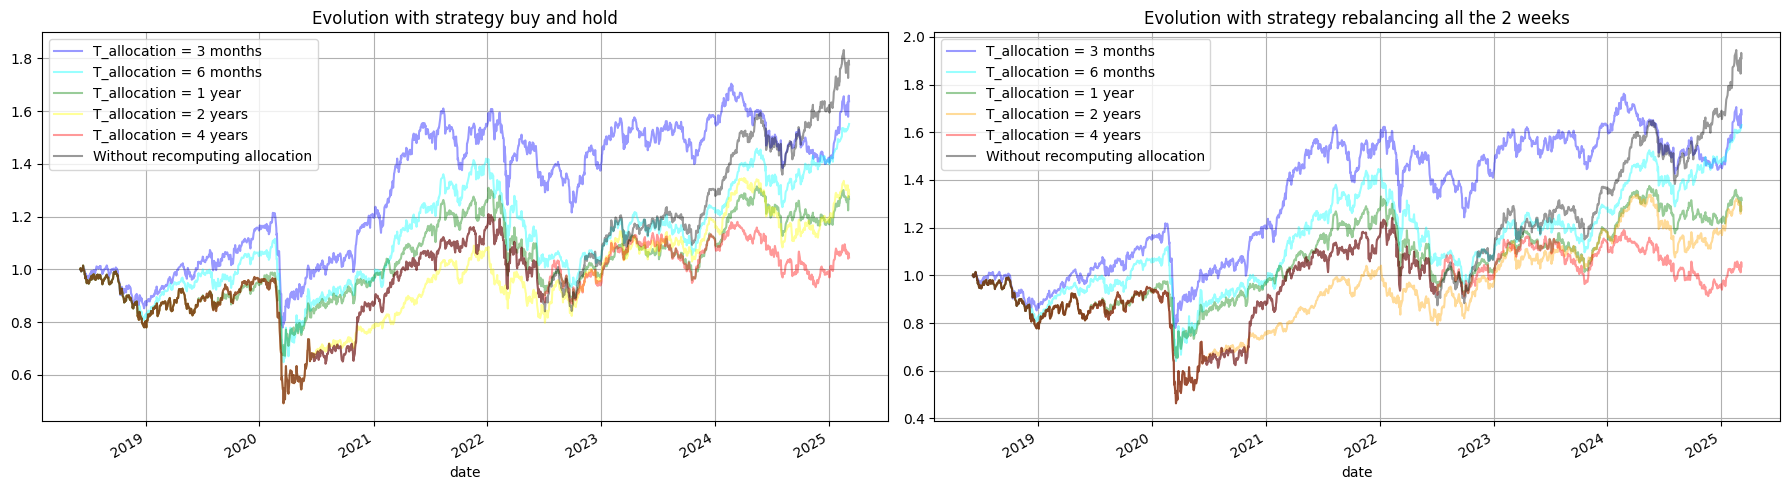

In [9]:
# Create subplot with 2 figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Plot buy and hold
evolution_BuyH_histo_Talloc3M = simulation_BuyH_histo_Talloc3M.evolutions
evolution_BuyH_histo_Talloc6M = simulation_BuyH_histo_Talloc6M.evolutions
evolution_BuyH_histo_Talloc1Y = simulation_BuyH_histo_Talloc1Y.evolutions
evolution_BuyH_histo_Talloc2Y = simulation_BuyH_histo_Talloc2Y.evolutions
evolution_BuyH_histo_Talloc4Y = simulation_BuyH_histo_Talloc4Y.evolutions
evolution_BuyH_histo_TallocWre = simulation_BuyH_histo_TallocWre.evolutions

for evolution_name, evolution_data in evolution_BuyH_histo_Talloc3M.items():
    evolution_data.sum(axis=1).plot(ax=ax1, color="blue", alpha=0.4, label="T_allocation = 3 months")
    evolution_BuyH_histo_Talloc6M[evolution_name].sum(axis=1).plot(ax=ax1, color="cyan", alpha=0.4, label="T_allocation = 6 months")
    evolution_BuyH_histo_Talloc1Y[evolution_name].sum(axis=1).plot(ax=ax1, color="green", alpha=0.4, label="T_allocation = 1 year")
    evolution_BuyH_histo_Talloc2Y[evolution_name].sum(axis=1).plot(ax=ax1, color="yellow", alpha=0.4, label="T_allocation = 2 years")
    evolution_BuyH_histo_Talloc4Y[evolution_name].sum(axis=1).plot(ax=ax1, color="red", alpha=0.4, label="T_allocation = 4 years")
    evolution_BuyH_histo_TallocWre[evolution_name].sum(axis=1).plot(ax=ax1, color="black", alpha=0.4, label="Without recomputing allocation")

ax1.set_title("Evolution with strategy buy and hold")
ax1.grid()
ax1.legend()

# Plot rebal 10
evolution_Rebal10_histo_Talloc3M = simulation_Rebal10_histo_Talloc3M.evolutions
evolution_Rebal10_histo_Talloc6M = simulation_Rebal10_histo_Talloc6M.evolutions
evolution_Rebal10_histo_Talloc1Y = simulation_Rebal10_histo_Talloc1Y.evolutions
evolution_Rebal10_histo_Talloc2Y = simulation_Rebal10_histo_Talloc2Y.evolutions
evolution_Rebal10_histo_Talloc4Y = simulation_Rebal10_histo_Talloc4Y.evolutions
evolution_Rebal10_histo_TallocWre = simulation_Rebal10_histo_TallocWre.evolutions

for evolution_name, evolution_data in evolution_Rebal10_histo_Talloc3M.items():
    evolution_data.sum(axis=1).plot(ax=ax2, color="blue", alpha=0.4, label="T_allocation = 3 months")
    evolution_Rebal10_histo_Talloc6M[evolution_name].sum(axis=1).plot(ax=ax2, color="cyan", alpha=0.4, label="T_allocation = 6 months")
    evolution_Rebal10_histo_Talloc1Y[evolution_name].sum(axis=1).plot(ax=ax2, color="green", alpha=0.4, label="T_allocation = 1 year")
    evolution_Rebal10_histo_Talloc2Y[evolution_name].sum(axis=1).plot(ax=ax2, color="orange", alpha=0.4, label="T_allocation = 2 years")
    evolution_Rebal10_histo_Talloc4Y[evolution_name].sum(axis=1).plot(ax=ax2, color="red", alpha=0.4, label="T_allocation = 4 years")
    evolution_Rebal10_histo_TallocWre[evolution_name].sum(axis=1).plot(ax=ax2, color="black", alpha=0.4, label="Without recomputing allocation")

ax2.set_title("Evolution with strategy rebalancing all the 2 weeks")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


#### Simulations without constraints

In [17]:
nb_simu = 50
#allocation = allocations_EW
allocation = CAC40_weights

parameters_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocation,
}
simulation_BuyH = Simulation(nb_scenarios=nb_simu, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

parameters_Rebal20 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocation,
    "Rebalancing period": 20
}
simulation_Rebal20 = Simulation(nb_scenarios=nb_simu, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal20)
simulation_Rebal20.set_scenarios(simulation_BuyH.scenarios)
simulation_Rebal20.generate_evolutions()

parameters_Rebal5 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocation,
    "Rebalancing period": 5
}
simulation_Rebal5 = Simulation(nb_scenarios=nb_simu, model=market_model_BS_CAC40, strategy="Rebalancing", parameters=parameters_Rebal5)
simulation_Rebal5.set_scenarios(simulation_BuyH.scenarios)
simulation_Rebal5.generate_evolutions()

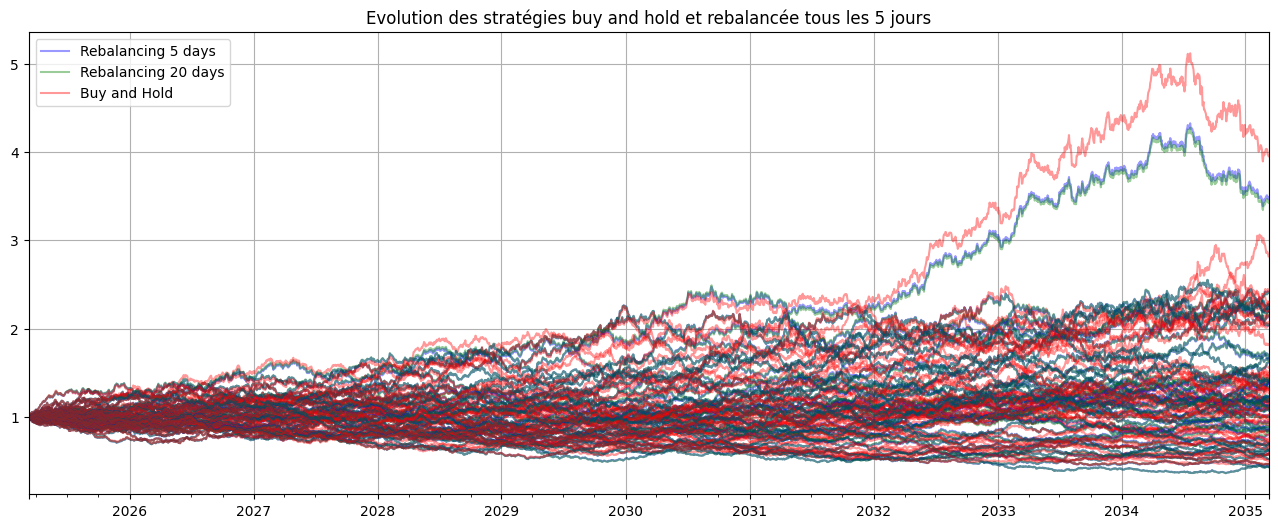

In [18]:
plt.figure(figsize=(16, 6))

lines = []
evolution_rebal5 = simulation_Rebal5.evolutions
evolution_BuyH = simulation_BuyH.evolutions
evolution_rebal20 = simulation_Rebal20.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal20[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 20 days"))
    lines.append(evolution_BuyH[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

#### Simulations with constraints

In [12]:
Nsce = 500

parameters_BuyH_sous_constrains = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10'
}
Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :]).T
#string to float
Data_esg = Data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
simulation_BuyH_sous_constrains = Simulation(nb_scenarios=Nsce, model=market_model_BS_CAC40, strategy="Buy and hold", parameters=parameters_BuyH_sous_constrains)
simulation_BuyH_sous_constrains.set_dataESG(Data_esg)
contraints = {
    "List" : ["Maximal allocation", "Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.2, 0.20, 3.5, 40, 65]
}
simulation_BuyH_sous_constrains.set_contraints(contraints)
simulation_BuyH_sous_constrains.compute_allocation()
simulation_BuyH_sous_constrains.generate_scenarios()
simulation_BuyH_sous_constrains.generate_evolutions()

# New simulation
# rebalance all 20 days and relax the constraints
parameters_BuyH_sous_constrains2 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Rebalancing period": 20
}
simulation_BuyH_sous_constrains2 = deepcopy(simulation_BuyH_sous_constrains)
simulation_BuyH_sous_constrains2.set_parameters(parameters_BuyH_sous_constrains2)
contraints2 = {
    "List" : ["Maximal allocation", "Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.2, 0.25, 7, 2000, 50]
}
simulation_BuyH_sous_constrains2.set_contraints(contraints2)
simulation_BuyH_sous_constrains2.compute_allocation()
simulation_BuyH_sous_constrains2.generate_evolutions()

c:\Users\Billn\Documents\M2QF\Cutting edge\Cutting-edge\Classes\simulation_interface.py:45: UserWarning: Strategy changed to 'Rebalancing'. Positive rebalancing period is not needed for Buy and hold strategy.
To avoid this warning, please use set_strategy() method to change the strategy before updating parameters.
  warnings.warn("Strategy changed to 'Rebalancing'. Positive rebalancing period is not needed for Buy and hold strategy.\n"


In [13]:
returns = market_model_BS_CAC40.parameters["Returns"]
volatilities = market_model_BS_CAC40.parameters["Volatilities"]
Correlation_matrix = market_model_BS_CAC40.parameters["Correlation matrix"]

#print vol et rendement allocation
allocation = simulation_BuyH_sous_constrains.parameters["Allocation"]
covMatrix = np.diag(volatilities) @ Correlation_matrix @ np.diag(volatilities)
portfolio_return = allocation @ returns
portfolio_variance = allocation @ covMatrix @ allocation
portfolio_Carbon_risk = allocation @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity = allocation @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management = allocation @ Data_esg["Score management"]

print("Portfolio 1:")
print(f"Portfolio return : {portfolio_return}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity}")
print(f"Portfolio Score management: {portfolio_score_management}")


#print vol et rendement allocation
allocation2 = simulation_BuyH_sous_constrains2.parameters["Allocation"]
portfolio_return2 = allocation2 @ returns
portfolio_variance2 = allocation2 @ covMatrix @ allocation2
portfolio_Carbon_risk2 = allocation2 @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity2 = allocation2 @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management2 = allocation2 @ Data_esg["Score management"]
print("\nPortfolio 2:")
print(f"Portfolio return: {portfolio_return2}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance2)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk2}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity2}")
print(f"Portfolio Score management: {portfolio_score_management2}")

Portfolio 1:
Portfolio return : 0.4888250659292623
Portfolio volatility: 0.15534370201842385
Portfolio Carbon risk: 3.4999999999729225
Portfolio Carbon intensity: 32.644476231597864
Portfolio Score management: 66.62547618842305

Portfolio 2:
Portfolio return: 0.6244448994324034
Portfolio volatility: 0.14146798615033654
Portfolio Carbon risk: 6.999999999614091
Portfolio Carbon intensity: 140.17217814324894
Portfolio Score management: 64.17028340137135


In [14]:
simulation_BuyH_sous_constrains.compute_metrics()
print(simulation_BuyH_sous_constrains.metrics)
print("\n")
simulation_BuyH_sous_constrains2.compute_metrics()
print(simulation_BuyH_sous_constrains2.metrics)

{'Mean terminal value': 1.3462, 'Median terminal value': 1.1729, 'Volatility of terminal value': 0.7481, 'VaR(95.0%)': 0.5192, 'ES(95.0%)': 0.43}


{'Mean terminal value': 1.3875, 'Median terminal value': 1.2259, 'Volatility of terminal value': 0.6444, 'VaR(95.0%)': 0.6287, 'ES(95.0%)': 0.5123}


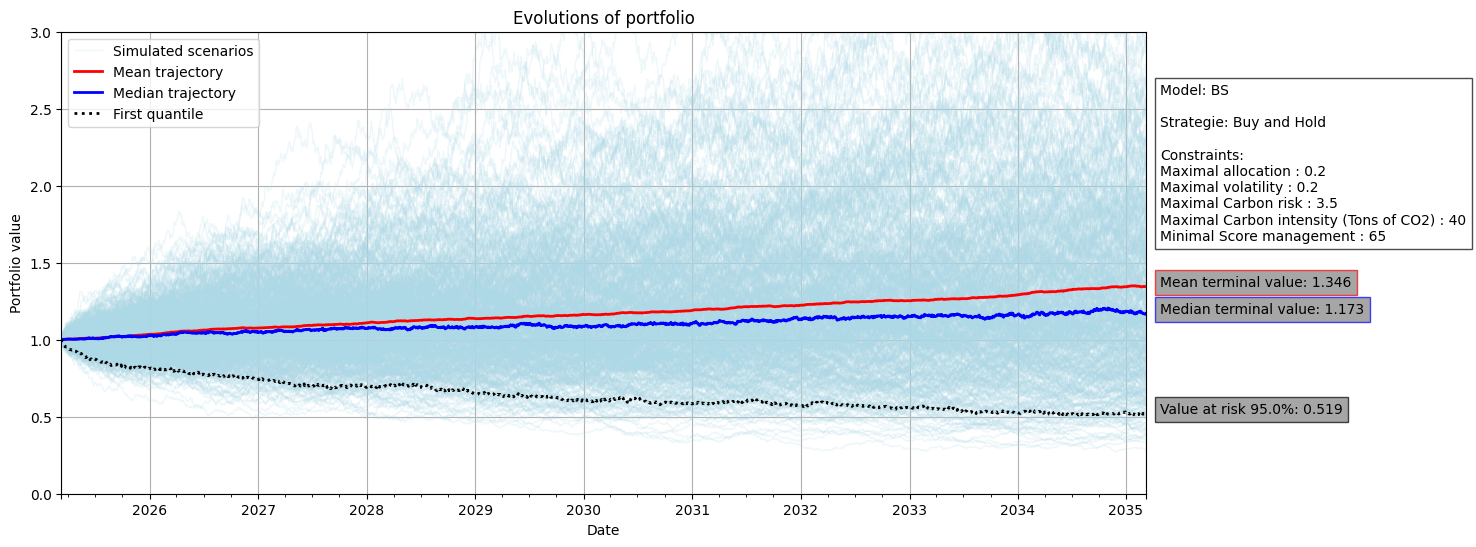

In [15]:
simulation_BuyH_sous_constrains.plot()

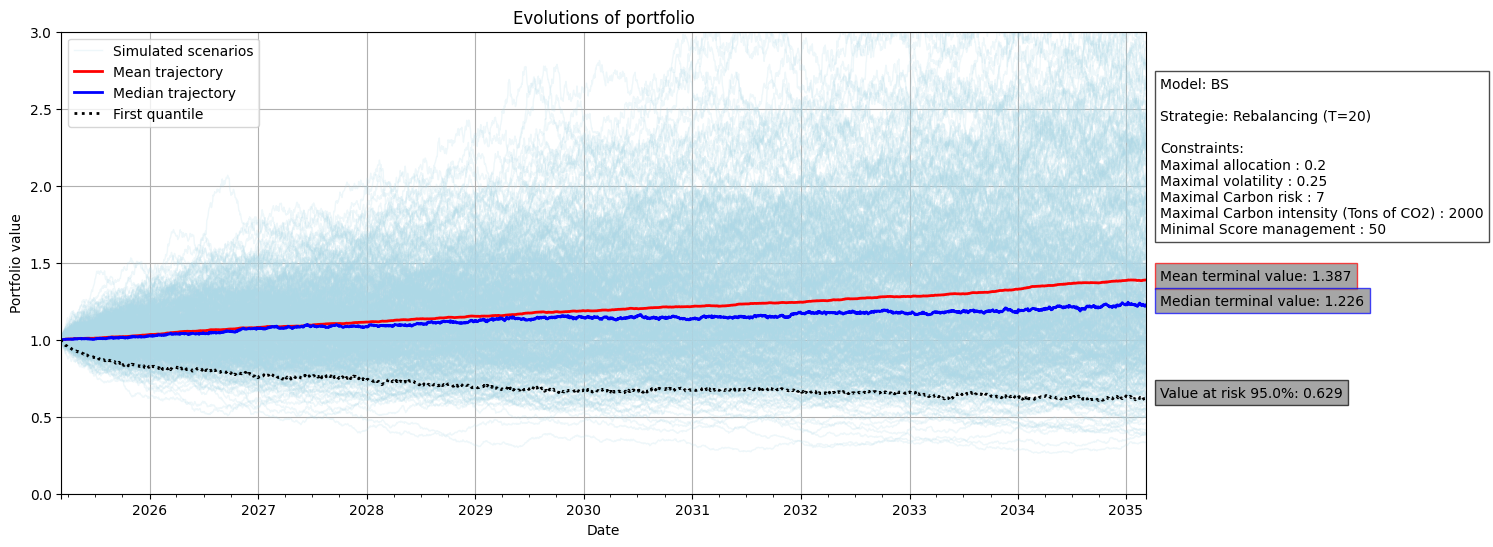

In [16]:
simulation_BuyH_sous_constrains2.plot()